## Documentation
Requirements:

get keras-segmentation with 'pip install keras-segmentation'. Refer to documentation https://github.com/divamgupta/image-segmentation-keras

Useful tutorials:

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html


Directory structure:
TODO

### Handseg dataset:
Width: 640, Height: 480. The annotated images contain three classes: background: 0, right_hand: 1, left_hand: 2.

Accessing the data:

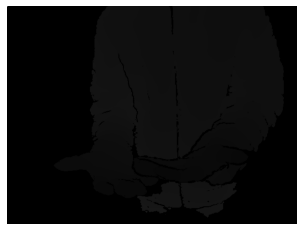

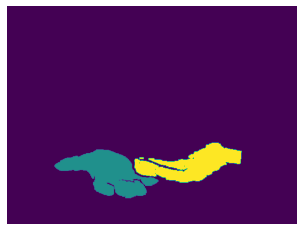

In [16]:
#path to the dataset
handseg_path = '../../../handseg-150k'
#depth_im = np.array(Image.open(Path(handseg_path+'/images/user-8.00008932.png')))# Loading depth image
mask_im = np.array(Image.open(Path(handseg_path+'/masks/user-4.00009545.png')))#  Loading mask image
#depth_im = depth_im.astype(np.float32)# Converting to float
#mean_depth_ims = 10000.0 # Mean value of the depth images
#depth_im /= mean_depth_ims # Normalizing depth image
depth_im = cv2.imread(handseg_path+'/images/user-4.00009545.png')


plt.imshow(depth_im); plt.axis('off'); plt.show() # Displaying Depth Image
plt.imshow(mask_im); plt.axis('off'); plt.show() # Displaying Mask Image

In [1]:
# Library header
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras import Model, Input
from tqdm import tqdm
import shutil #library for moving files
import tensorflow as tf
import numpy as np
import cv2
import glob

# own libraries
import split_dataset as spData
import handseg_model as hand
import handseg_two_classes as hand2
import data_gen as dg


#globals
input_width = 640
input_height = 480
handseg_path = '../../../handseg-150k'

0.2.9


In [2]:
# input is a (480, 640, 2) np.array -> interpret the softmax values in third dimension
def interpretPrediction(pred):
  # create np.array to save the interpretation
  interpretation = np.zeros((480, 640))
  height, width, _ = pred.shape
  for i in range(height):
    for j in range(width):
      # create a list of the probabilites from each class
      value_list = [pred[i,j,0], pred[i,j,1]]
      # find out, which class has been predicted
      largest = max(value_list)
      index_of_largest = value_list.index(largest)
      # store new value in the interpretation array
      interpretation[i,j] = index_of_largest
  return interpretation


def drawBoxes(mask, img):
    x = -1; y = -1; w = -1; h = -1
    # Iterate all colors in mask
    for color in np.unique(mask):

        # Color 0 is assumed to be background or artifacts
        if color == 0:
          continue

        # Determine bounding rectangle w.r.t. all pixels of the mask with
        # the current color
        x, y, w, h = cv2.boundingRect(np.uint8(mask == color))
        # Draw bounding rectangle to color image
        out = cv2.rectangle(img.copy(), (x, y), (x+w, y+h), (255, int(color), 0), 2)

        # Show image with bounding box
        plt.imshow(out, cmap="Greys"); plt.title('img_' + str(color)); plt.show()
    return x, y, w, h

        
def getIOU(predicted, ground_truth):
    # IoU calculation
    intersection = np.logical_and(ground_truth, predicted)
    union = np.logical_or(ground_truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    print("IoU is ", iou_score)

# preprocessing
def preprocess(img):
    return (img / img.max()) * 255

In [ ]:
# create the data generators with data_loader
# ... for training
train_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/images/",
        segs_path=handseg_path+"/masks/", 
        batch_size=16,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        do_augment=True,
        preprocessing=preprocess,
        read_image_type=1)
# read_image_type -> 0 = grayscale; -> 1 = rgb

# ... for validation
val_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/val_images/",
        segs_path=handseg_path+"/val_masks/",
        batch_size=2,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        preprocessing=preprocess,
        read_image_type=1)

# ... for testing
test_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/test_images/",
        segs_path=handseg_path+"/test_masks/",
        batch_size=2,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        preprocessing=preprocess,
        read_image_type=1)

In [3]:
# Initialize the model
inputs = Input(shape=(480, 640, 3))
handseg = Model(inputs=inputs, outputs=hand2.handseg_model(inputs), name="HandSeg_Model")
handseg.summary()

# build the segmentation model
handseg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])

Model: "HandSeg_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 240, 320, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 160, 128 73856       leaky_re_lu[0][0]                
______________________________________________________________________________________

(1, 480, 640, 3)


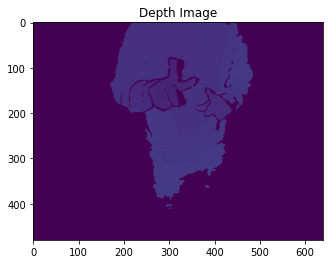

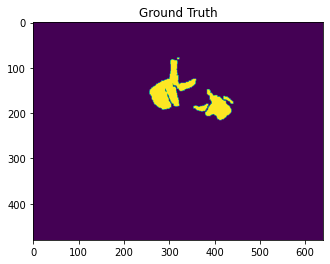

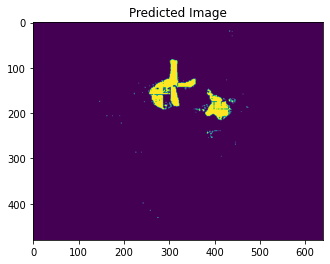

IoU value:  0.88229686


In [6]:
handseg.load_weights("../../../results/weights/twoClasses/handseg_model_twoClasses_4.h5")



image_path = "/test_images/user-2.00000486.png"
mask_path = "/test_masks/user-2.00000486.png"

depth_im = np.array(Image.open(Path(handseg_path+image_path)))
mask_im = np.array(Image.open(Path(handseg_path+mask_path)))
mask_im = tf.where(mask_im == 2, 1, mask_im).numpy()

in_image = cv2.imread(handseg_path+image_path)
in_image = np.reshape(in_image, (1,480, 640, 3))
in_image = preprocess(in_image)
print(in_image.shape)
out_im = handseg.predict(in_image)
out_im = interpretPrediction(out_im[0])

plt.imshow(depth_im); plt.title('Depth Image'); plt.show()
plt.imshow(mask_im); plt.title('Ground Truth'); plt.show()
plt.imshow(out_im); plt.title('Predicted Image'); plt.show()


m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(mask_im, out_im)
print("IoU value: ", m.result().numpy())

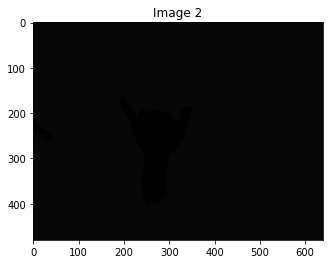

(480, 640, 3)


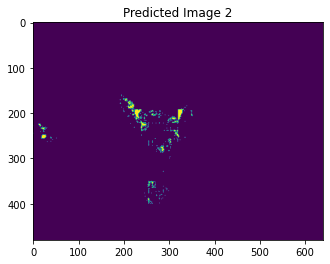

(480, 640, 3) (480, 640, 2)
0.4401667
0 160 352 240


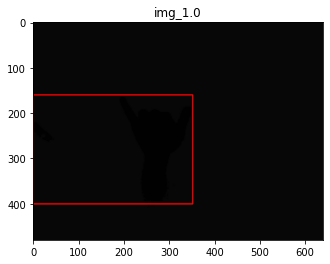

In [19]:
handseg.load_weights("../../../results/weights/twoClasses/handseg_model_twoClasses_2.h5")


im_2 = cv2.imread(handseg_path+"/predict/depth_1_0000045.png")
im_2 = cv2.resize(im_2, (640, 480))
plt.imshow(im_2); plt.title('Image 2'); plt.show()
print(im_2.shape)
im_2 = np.reshape(im_2, (1,480, 640, 3))
im_2 = preprocess(im_2)
out_im_2 = handseg.predict(im_2)
out_im_2_pred = interpretPrediction(out_im_2[0])
plt.imshow(out_im_2_pred); plt.title('Predicted Image 2'); plt.show()

# check iou
gt = cv2.imread(handseg_path+mask_path)
m = tf.keras.metrics.MeanIoU(num_classes=3)

print(gt.shape, pred[0].shape)

m.update_state(gt[:,:,0], interpretPrediction(pred[0]))
print(m.result().numpy())

# draw box
im_3 = cv2.imread(handseg_path+"/predict/depth_1_0000045.png")
im_3 = cv2.resize(im_3, (640, 480))
drawBoxes(out_im_2_pred, im_3)

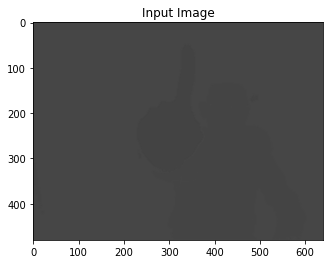

[66 67 68 69 70 71]


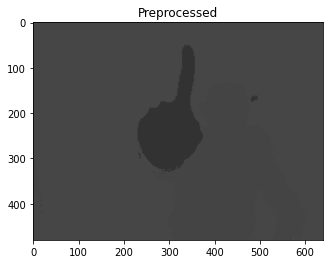

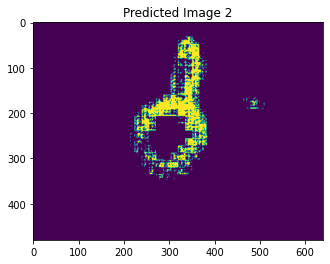

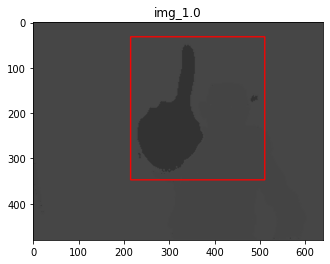

(215, 32, 296, 315)


In [7]:
handseg.load_weights("../../../results/weights/twoClasses/handseg_model_twoClasses_4.h5")

def preprocess2(img):
    #img = img.max() - img
    #img = tf.where(img < 100, 5, img).numpy()
    img = tf.where(img < 68, 50, img).numpy()
    #img = tf.where(img > 70, 125, img).numpy()
    #img = img - img.min()
    #img = img/img.max()
    return img

def preprocess3(img):
    img = tf.where(img > 25, 255, img).numpy()
    img = tf.where(img < 25, 50, img).numpy()
    img = tf.where(img == 255, 125, img).numpy()
    return img

name = "./fingerspelling/S01_C01_0000.bin"


depth_map = np.fromfile(name, dtype='uint8')
depth_map = depth_map.reshape(240,320,4)
temp_map_1 = cv2.resize(depth_map[:,:,2], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
temp_map_2 = cv2.resize(depth_map[:,:,3], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
# save image
cv2.imwrite('test_depth_1.png',temp_map_1)
cv2.imwrite('test_depth_2.png',temp_map_2)


# load image
depth_map = cv2.imread("./test_depth_2.png")
plt.imshow(depth_map); plt.title('Input Image'); plt.show()
print(np.unique(depth_map))

# Preprocessing
im = np.reshape(depth_map, (1,480, 640, 3))
im = preprocess2(im)
plt.imshow(im[0]); plt.title('Preprocessed'); plt.show()

# predict
out_im = handseg.predict(im)
out_im_pred = interpretPrediction(out_im[0])
plt.imshow(out_im_pred); plt.title('Predicted Image 2'); plt.show()

# draw box
ground = cv2.imread("./test_depth_2.png")
ground = cv2.resize(ground, dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
ground = preprocess2(ground)
tupel_val = drawBoxes(out_im_pred, ground)
print(tupel_val)

(240, 320, 4)


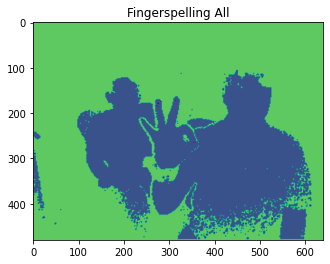

In [103]:
name = "./fingerspelling/S03_C09_0154.bin"


depth_map = np.fromfile(name, dtype='uint8')
depth_map = depth_map.reshape(240,320,4)
print(depth_map.shape)

temp_map_1 = cv2.resize(depth_map[:,:,0], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
temp_map_2 = cv2.resize(depth_map[:,:,1], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
temp_map_3 = cv2.resize(depth_map[:,:,2], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
temp_map_4 = cv2.resize(depth_map[:,:,3], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)

temp_map_5 = cv2.resize(depth_map, dsize=(640, 480), interpolation=cv2.INTER_AREA)

#temp_map_4 = preprocess(temp_map_3)
cv2.imwrite('test_depth.png',temp_map_4)
plt.imshow(temp_map_4); plt.title("Fingerspelling All"); plt.show()

(307200,)


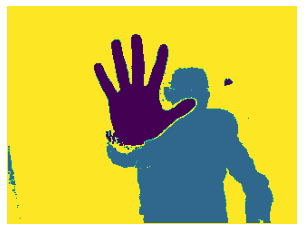

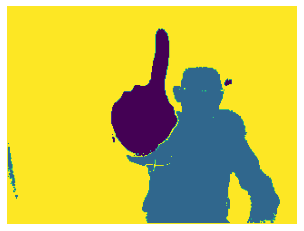

In [32]:
# read binary file
name = "./S01_C01_0000.bin" 
name2 = "./S01_C01_0025.bin"
name3 = "./S01_C05_0190.bin"

depth_map = np.fromfile(name3, dtype='uint8')
depth_map_1 = np.fromfile(name, dtype='uint8')
print(depth_map.shape)
depth_map = depth_map.reshape(240,320,4)
depth_map_1 = depth_map_1.reshape(240,320,4)
#cv2.imwrite('bash1.png', depth_map[0])
plt.imshow(depth_map[:,:,3]); plt.axis('off'); plt.show()
plt.imshow(depth_map_1[:,:,3]); plt.axis('off'); plt.show()
#hot, gray_r